<a href="https://colab.research.google.com/github/handsome1201/AI_Challenge/blob/main/%EC%86%8C%ED%94%84%ED%8A%B8%EC%9B%A8%EC%96%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import time
import datetime
import easydict
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torchvision
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.optim import SGD, AdamW
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [141]:
args = easydict.EasyDict({
    # device setting
    'device': 0,
    'seed' : 123,

    # training setting
    'batch_size' : 256,  # Increased batch size for potentially faster training
    'num_workers' : 4,  # Increased number of workers for data loading
    'epoch' : 250,  # Increased number of epochs for more training iterations
    'num_cls' : 100,
    'resample' : True,

    # optimizer & criterion
    'lr' : 0.001,  # Decreased learning rate for potentially more stable convergence
    'momentum' : 0.9,
    'weight_decay' : 5e-5,  # Slightly increased weight decay for better regularization
    'nesterov' : True,

    # directory
    'data_path' : '/content/drive/MyDrive/소프트웨어/Data',
    'save_path' : '/content/drive/MyDrive/소프트웨어/Save',

    # etc
    'print_freq' : 10,  # Increased print frequency for more frequent updates during training
    'threshold' : 0.7,  # Adjusted threshold for binary classification based on requirements
})

def setup(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if args.seed is not None:
        random.seed(args.seed)
        np.random.seed(args.seed)
        torch.random.manual_seed(args.seed)
    return device

In [119]:
# load data_preprocessing module
sys.path.append(args.data_path)

In [120]:
def load_data(data_path, train_transform, test_transform):
    start = time.time()
    train_dataset = CIFAR100(root=data_path, train=True, download=True, transform=train_transform)
    test_dataset = CIFAR100(root=data_path, train=False, download=True, transform=test_transform)
    end = time.time()
    sec = end - start
    print(f"Completed Loading dataset at {str(datetime.timedelta(seconds=sec)).split('.')[0]}")
    return train_dataset, test_dataset

In [121]:
# Load dataset
train_dataset, test_dataset = load_data(args.save_path, transforms.ToTensor(), transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified
Completed Loading dataset at 0:00:02


In [122]:
args.num_features = train_dataset.data.shape[1]
args.num_classes = len(np.unique(train_dataset.targets))
print(f"Train_shape: {train_dataset.data.shape}")
print(f"Test_shape: {test_dataset.data.shape}")
print(f"Number of classes: {len(np.unique(train_dataset.targets))}")

Train_shape: (50000, 32, 32, 3)
Test_shape: (10000, 32, 32, 3)
Number of classes: 100


In [123]:
num_balance = [np.sum(np.array(train_dataset.targets) == i) for i in np.unique(train_dataset.targets)]

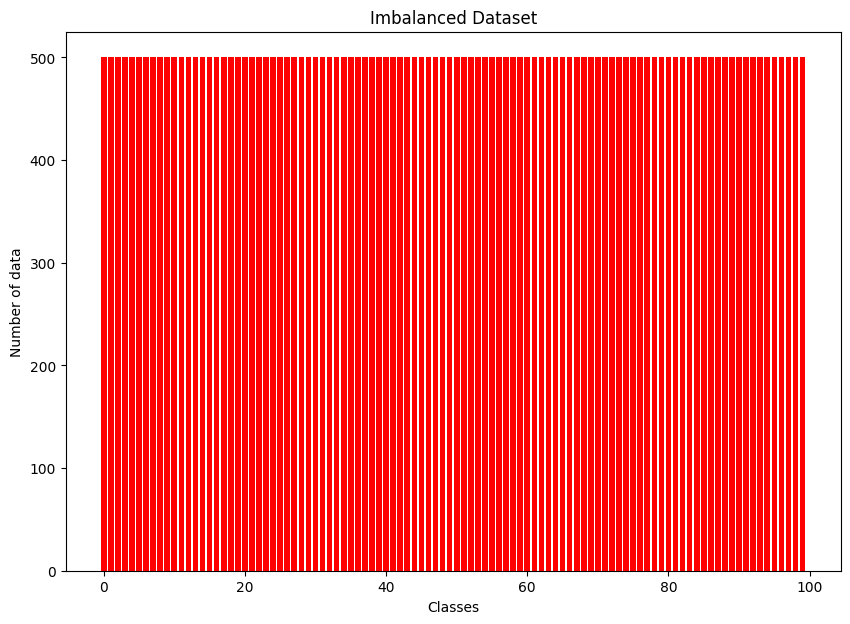

In [124]:
fig = plt.figure(figsize=(10,7), dpi=100)
ax = fig.subplots()
ax.bar(range(len(np.unique(train_dataset.targets))), num_balance, color='red')
ax.set_title("Imbalanced Dataset")
_= ax.set_ylabel("Number of data")
_= ax.set_xlabel("Classes")
fig.show()

In [125]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, type='train', indices=None, num_samples=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset.targets))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = [0] * len(np.unique(dataset.targets))
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            label_to_count[label] += 1

        beta = 0.9999
        effective_num = 1.0 - np.power(beta, label_to_count)
        per_cls_weights = (1.0 - beta) / np.array(effective_num)

        # weight for each sample
        weights = [per_cls_weights[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.targets[idx]

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, replacement=True).tolist())

    def __len__(self):
        return self.num_samples

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = LambdaLayer(lambda x:
                                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet32(num_classes=100):
    return ResNet_s(BasicBlock, [5, 5, 5], num_classes=num_classes)

In [126]:
class Metric:
    def __init__(self, header='', fmt='{val:.4f} ({avg:.4f})'):
        """Base Metric Class
        :arg
            fmt(str): format representing metric in string
        """
        self.val = 0
        self.sum = 0
        self.n = 0
        self.avg = 0
        self.header = header
        self.fmt = fmt

    def update(self, val, n=1):
        if isinstance(val, torch.Tensor):
            val = val.detach().clone()

        self.val = val
        self.sum += val * n
        self.n += n
        self.avg = self.sum / self.n

    def compute(self):
        return self.avg

    def __str__(self):
        return self.header + ' ' + self.fmt.format(**self.__dict__)

def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch = epoch + 1
    if epoch <= 5:
        lr = args.lr * epoch / 5
    elif epoch > 180:
        lr = args.lr * 0.0001
    elif epoch > 160:
        lr = args.lr * 0.01
    else:
        lr = args.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_one_epoch(model, train_dataloader, optimizer, criterion, epoch, args):
    # 1. create metric
    data_m = Metric(header='Data:')
    batch_m = Metric(header='Batch:')
    loss_m = Metric(header='Loss:')

    # 2. start validate
    model.train()

    total_iter = len(train_dataloader)
    start_time = time.time()

    for batch_idx, (x, y) in enumerate(train_dataloader):
        batch_size = x.size(0)

        x = x.to(args.device)
        y = y.to(args.device)

        data_m.update(time.time() - start_time)

        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_m.update(loss, batch_size)

        if batch_idx and args.print_freq and batch_idx % args.print_freq == 0:
            num_digits = len(str(total_iter))
            print(f"TRAIN({epoch:03}): [{batch_idx:>{num_digits}}/{total_iter}] {batch_m} {data_m} {loss_m}")

        batch_m.update(time.time() - start_time)
        start_time = time.time()

    # 3. calculate metric
    duration = str(datetime.timedelta(seconds=batch_m.sum)).split('.')[0]
    data = str(datetime.timedelta(seconds=data_m.sum)).split('.')[0]
    f_b_o = str(datetime.timedelta(seconds=batch_m.sum - data_m.sum)).split('.')[0]
    loss = loss_m.compute()

    # 4. print metric
    space = 16
    num_metric = 5
    print('-'*space*num_metric)
    print(("{:>16}"*num_metric).format('Stage', 'Batch', 'Data', 'F+B+O', 'Loss'))
    print('-'*space*num_metric)
    print(f"{'TRAIN('+str(epoch)+')':>{space}}{duration:>{space}}{data:>{space}}{f_b_o:>{space}}{loss:{space}.4f}")
    print('-'*space*num_metric)

    return loss

def prediction_submission(predict, args):
    """
    테스트 데이터의 idx와 예측한 prediction label을 submission.csv로 저장
    """
    submission = [[idx, label] for idx, label in enumerate(predict)]
    df = pd.DataFrame(data=submission, columns=['id_idx', 'label'], index=None)
    args.save_path = Path(args.save_path)
    args.save_path.mkdir(exist_ok=True)
    df.to_csv(args.save_path / 'submission.csv', index=False)

def test_submission(model, test_dataloader, args):
    """
    학습한 모델로 테스트 데이터의 라벨을 예측하고 그 결과를 submission.csv로 저장
    """
    model_predict = [] # for submission.csv
    for x,y in test_dataloader:
        x = x.to(args.device)
        y = y.to(args.device)
        output = model(x)
        _, prediction = torch.max(output, 1)
        model_predict.extend(prediction.cpu().numpy())
    prediction_submission(model_predict, args)

In [136]:
def run(args):
    start = time.time()
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    # 1. load train, test dataset
    train_dataset, test_dataset = load_data(args.save_path, transform_train, transform_val)
    train_sampler = None
    if args.resample:
        train_sampler = ImbalancedDatasetSampler(train_dataset)
        per_cls_weights = None
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=(args.resample is False),
                                  num_workers=args.num_workers, sampler=train_sampler)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

    cudnn.benchmark = True
    # 2. create model
    model = resnet32().to(args.device)

    # 3. optimizer, criterion
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-6, momentum=0.9, nesterov=True)
    # 각 클래스의 샘플 수를 계산합니다.
    class_counts = np.bincount(train_dataset.targets)

    # 클래스 가중치를 계산합니다. 소수 클래스에 더 큰 가중치가 부여됩니다.
    class_weights = 1. / class_counts

    # 텐서로 변환합니다.
    weights = torch.FloatTensor(class_weights).to(args.device)

    # 가중치를 손실 함수에 적용합니다.
    criterion = nn.CrossEntropyLoss(weight=weights)

#     criterion = nn.CrossEntropyLoss()

    # 4. train & validate
    for epoch in range(args.epoch):
        adjust_learning_rate(optimizer, epoch, args)
        train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, epoch, args)

    test_submission(model, test_dataloader, args)
    end = time.time()
    sec = end - start
    print(f"Finished Training & Test at {str(datetime.timedelta(seconds=sec)).split('.')[0]} ....")

In [128]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, type='train', indices=None, num_samples=None):

        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset.targets))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = [0] * len(np.unique(dataset.targets))
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            label_to_count[label] += 1

        beta = 0.9999
        effective_num = 1.0 - np.power(beta, label_to_count)
        per_cls_weights = (1.0 - beta) / np.array(effective_num)

        # weight for each sample
        weights = [per_cls_weights[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.targets[idx]

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, replacement=True).tolist())

    def __len__(self):
        return self.num_samples

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = LambdaLayer(lambda x:
                                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet32(num_classes=100):
    return ResNet_s(BasicBlock, [5, 5, 5], num_classes=num_classes)

In [142]:
setup(args)
run(args)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
TRAIN(041): [180/196] Batch: 0.0774 (0.0789) Data: 0.0546 (0.0511) Loss: 2.7528 (2.8125)
TRAIN(041): [190/196] Batch: 0.0759 (0.0787) Data: 0.0609 (0.0513) Loss: 2.8511 (2.8143)
--------------------------------------------------------------------------------
           Stage           Batch            Data           F+B+O            Loss
--------------------------------------------------------------------------------
       TRAIN(41)         0:00:15         0:00:10         0:00:05          2.8156
--------------------------------------------------------------------------------
TRAIN(042): [ 10/196] Batch: 0.0629 (0.1191) Data: 0.0571 (0.0864) Loss: 2.7523 (2.8310)
TRAIN(042): [ 20/196] Batch: 0.0730 (0.0982) Data: 0.0530 (0.0692) Loss: 2.7154 (2.8137)
TRAIN(042): [ 30/196] Batch: 0.0780 (0.0911) Data: 0.0515 (0.0630) Loss: 2.8329 (2.8146)
TRAIN(042): [ 40/196] Batch: 0.0810 (0.0872) Data: 0.0568 (0.0601) Loss: 2.6713 (2.8130)
TRAIN(042): [ 50/196] Bat

In [143]:
# check submission.csv
pd.read_csv(args.save_path / 'submission.csv', index_col=False)

,id_idx,label
0,0,30
1,1,33
2,2,55
3,3,51
4,4,60
...,...,...
9995,9995,83
9996,9996,3
9997,9997,51
9998,9998,66
